In [1]:
import numpy as np
import os
import re
import matplotlib.colors as colors

from scipy.ndimage import filters

In [2]:
data = []
i = 0
clipped=True
while True:
    try:
        l = np.load('l{0}.npy'.format(i)).astype(np.float)
        gt = np.load('g{0}.npy'.format(i)).astype(np.float)
        costs = np.load('b{0}.npy'.format(i)).astype(np.float)
        acosts = np.load('a{0}.npy'.format(i)).astype(np.float)
        box_costs = (filters.uniform_filter(costs,[7,7,1],mode='nearest')*(7*7)).astype(np.int)
        
        if clipped:
            costs = np.clip(costs,0,costs.mean()-costs.std())
            box_costs = np.clip(box_costs,0,box_costs.mean()-box_costs.std())

        best = np.argmin(box_costs,2)
    except:
        break
    max_disp = int(costs.shape[-1])
    image_width = costs.shape[1]
    image_height = costs.shape[0]
    data_size = costs.shape[0]*costs.shape[1]
    mask = np.ones_like(gt)
    mask[np.where(gt < 0)] = 0
    print gt.shape,gt.max(),costs.max(),acosts.max(),box_costs.max()
    for y in xrange(image_height):
        for x in xrange(1,image_width):
            gp = gt[y,x-1]
            gn = gt[y,x]

            #if best[y,x] != int(round(gt[y,x])):
            #    continue
            #if gp == -2 or gp == -1 or gn == -2 or gn == -1:
            #    continue
            #if gp == -2 or gn == -2:
            #    continue
            ft = [gp,gn,gn - gp,round(gn)-round(gp)]

            for img in [l,costs,box_costs]:
                cp = img[y,x-1,:]
                cn = img[y,x,:]
                ft.append((cn - cp).mean())
            data.append(ft)
    for y in xrange(1,image_height):
        for x in xrange(image_width):
            gp = gt[y-1,x]
            gn = gt[y,x]
            
            #if best[y,x] != int(round(gt[y,x])):
            #    continue
            #if gp == -2 or gp == -1 or gn == -2 or gn == -1:
            #    continue
            #if gp == -2 or gn == -2:
            #    continue
            ft = [gp,gn,gn - gp,round(gn)-round(gp)]

            for img in [l,costs,box_costs]:
                cp = img[y-1,x,:]
                cn = img[y,x,:]
                ft.append(((cn - cp)).mean())
            data.append(ft)
    i = i + 1
    print len(data)
data = np.array(data)

(496L, 718L) 63.0447998047 6.05292758213 658.0 399.125245975
711042
(497L, 741L) 62.8773498535 5.86118968164 764.0 389.180700013
1446358
(481L, 707L) 51.4406738281 4.36044022262 675.0 292.687074929
2125304
(485L, 735L) 67.2837219238 5.62601469014 725.0 372.094741242
2837034
(476L, 699L) 73.5487670898 5.90141477323 713.0 388.803409725
3501307
(463L, 680L) 66.438293457 5.92064085208 726.0 389.010633736
4129844
(486L, 720L) 55.8516235352 5.25658362265 638.0 343.142607567
4828478
(497L, 738L) 50.4529876709 4.25058941885 704.0 295.765465816
5560815
(375L, 450L) 52.75 5.63302859452 640.0 380.965244188
5897490


In [3]:
print data.shape
import pandas as pd
data_f = pd.DataFrame(data,columns=['l','r','fp_gt','i_gt','rgbdiff','cmdiff','amdiff'])
data_f = data_f[((data_f.l != -2) & (data_f.r != -2) & (data_f.l != -1) & (data_f.r != -1))]
data_f['gt'] =  (((data_f.l != -2) & (data_f.r != -2) & (data_f.fp_gt.abs() > 2.0)) | ((data_f.l == -2) |(data_f.r == -2))).astype(np.int)
total = np.array(data_f[['gt','rgbdiff','cmdiff']])
edge = (data_f['gt'] == 1).sum()
nonedge = (data_f['gt'] == 0).sum()
print edge,nonedge,edge/float(nonedge)*100.0
data_f.max()

(5897490L, 7L)
32484 4937990 0.657838513241


l           73.548767
r           73.548767
fp_gt       49.746841
i_gt        50.000000
rgbdiff    183.666667
cmdiff       6.052928
amdiff     120.200000
gt           1.000000
dtype: float64

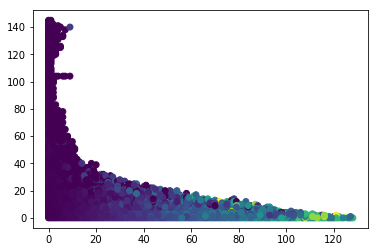

In [4]:
def hist2d(z,nbins=10):
    
    x = z[:,1]
    y = z[:,2]
    verification = z[:,0]
    print x.max(),x.min()
    print y.max(),y.min()
    print verification.max(),verification.min()
    _, xedges, yedges = np.histogram2d(x,y,bins=nbins)
    avgarr = np.zeros((nbins, nbins))
    H = np.zeros((nbins,nbins))
    # determine the X and Y bins each sample coordinate belongs to
    xbins = np.digitize(x, xedges[1:-1])
    ybins = np.digitize(y, yedges[1:-1])

    # calculate the bin sums (note, if you have very many samples, this is more
    # effective by using 'bincount', but it requires some index arithmetics
    for xb, yb, v in zip(xbins, ybins, verification):
        avgarr[yb, xb] += v
        H[yb,xb]+=1

    # replace 0s in H by NaNs (remove divide-by-zero complaints)
    # if you do not have any further use for H after plotting, the
    # copy operation is unnecessary, and this will the also take care
    # of the masking (NaNs are plotted transparent)
    divisor = H.copy()
    divisor[divisor==0.0] = np.nan

    # calculate the average
    avgarr /= divisor
    return avgarr,xedges,yedges,H

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%matplotlib inline

plt.figure()
if False:
    plt.plot(abs(grad[gidx,0]),abs(grad[gidx,1]),ms=5,lw=0,marker='.')
    plt.plot(abs(no_grad[nidx,0]),abs(no_grad[nidx,1]),ms=5,lw=0,marker='.')

    plt.grid(True)
if False:
    plt.hexbin(abs(grad[:,0])+1,abs(grad[:,1])+1)
    plt.figure(figsize=(15,15))
    plt.hexbin(abs(no_grad[:,0])+1,abs(no_grad[:,1])+1)
if False:
    res,xbins,ybins,H = hist2d(abs(total),20)
    plt.imshow(res,origin='lower')
    plt.xlabel('color')
    plt.xticks(np.arange(20),np.unique(xbins))
    plt.yticks(np.arange(20),np.unique(ybins))
    plt.ylabel('sum disp diff')
    plt.colorbar()
    plt.figure()
    plt.imshow(res > 0.5,origin='lower')
    plt.figure()
    plt.imshow(H,origin='lower',norm=LogNorm())
    plt.colorbar()
if True:
    from collections import defaultdict
    cntr = defaultdict(float)
    prob = defaultdict(float)
    xscale = 1.0
    yscale = 24.0
    for z,x,y in abs(total):
        cntr[(int(x*xscale),int(y*yscale))] += z
        prob[(int(x*xscale),int(y*yscale))] += 1
    bad_keys = []
    for key in cntr:
        cntr[key] = cntr[key] / prob[key]
        if prob[key] < 15:
            bad_keys.append(key)
    for key in bad_keys:
        del cntr[key]
    x = []
    y = []
    c = []
    c2 = []
    for key in cntr:
        x.append(key[0])
        y.append(key[1])
        c.append(cntr[key])
        c2.append(prob[key])

    plt.scatter(x,y,c=c)



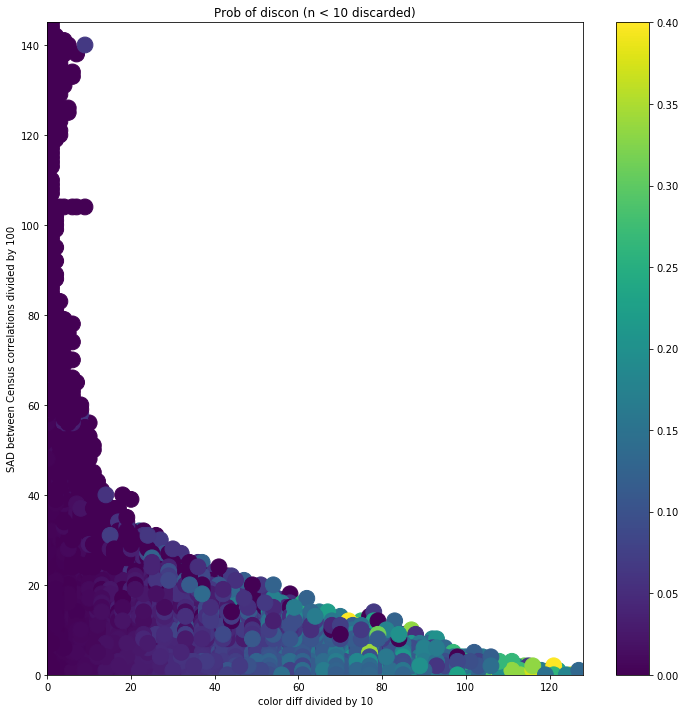

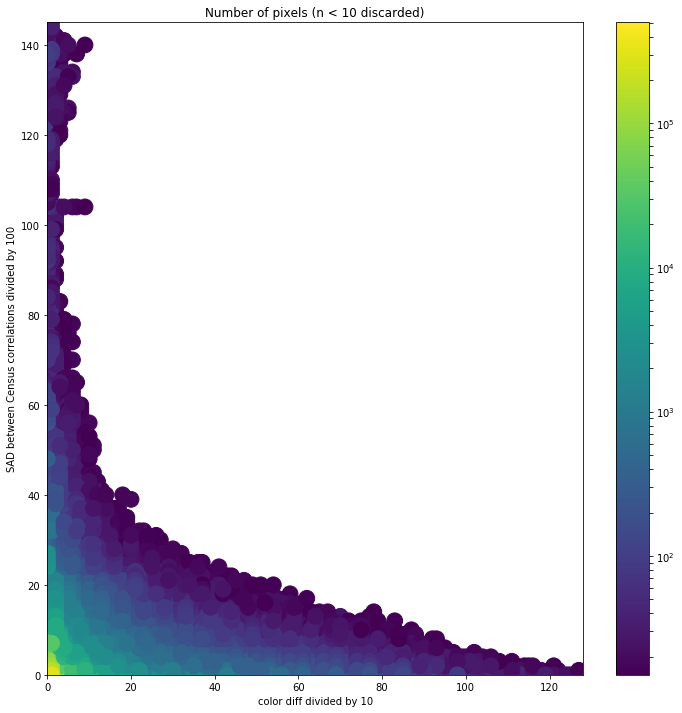

In [5]:
plt.figure(figsize=(12,12))
plt.scatter(x,y,c=c,s=250)#, norm=LogNorm())
plt.title('Prob of discon (n < 10 discarded)')
plt.ylabel('SAD between Census correlations divided by 100')
plt.xlabel('color diff divided by 10')
plt.grid(False)
plt.xlim(0,max(x))
plt.ylim(0,max(y))
plt.colorbar()
plt.figure(figsize=(12,12))
plt.scatter(x,y,c=c2,s=250, norm=LogNorm())
plt.title('Number of pixels (n < 10 discarded)')
plt.ylabel('SAD between Census correlations divided by 100')
plt.xlabel('color diff divided by 10')
plt.grid(False)
plt.xlim(0,max(x))
plt.ylim(0,max(y))
plt.colorbar()

In [6]:
if False:
    plt.figure(figsize=(10,10))
    print total[total[:,0] == 0].shape,total[total[:,0] == 1].shape,total.shape
    nondisc = abs(np.round(total[total[:,0] == 0])[:,1:])
    disc = abs(np.round(total[total[:,0] == 1])[:,1:])
    disc_cnt = np.array(total[:,1].max(),total[:,1].max())
    plt.hexbin(disc[:,0],disc[:,1],norm=LogNorm())
    plt.xlim(0,total[:,1].max())
    plt.ylim(0,total[:,2].max())
    plt.title('Distribution of disc pixels')
    plt.ylabel('MAD between Census correlations')
    plt.xlabel('SAD between colors')
    
    plt.figure(figsize=(10,10))
    plt.hexbin(nondisc[:,0],nondisc[:,1],norm=LogNorm())
    plt.xlim(0,total[:,1].max())
    plt.ylim(0,total[:,2].max())
    plt.title('Distribution of nondisc pixels')
    plt.ylabel('MAD between Census correlations')
    plt.xlabel('SAD between colors')
else:
    scale = np.array([1.0,1.0,10.0]).astype(np.float32)
    
    print scale
    print total[total[:,0] == 0].shape,total[total[:,0] == 1].shape,total.shape,total.max(axis=0),total.std(axis=0)
    nondisc = abs(np.round(scale*total[total[:,0] == 0])[:,1:])
    disc = abs(np.round(scale*total[total[:,0] == 1])[:,1:])
    disc_cnt = np.zeros(np.max(abs(np.round(scale*total)),0)[1:] + 1)
    for x,y in disc:
        disc_cnt[x,y] += 1

    nondisc_cnt = np.zeros(np.max(abs(np.round(scale*total)),0)[1:] + 1)
    for x,y in nondisc:
        nondisc_cnt[x,y] += 1

[  1.   1.  10.]
(4937990L, 3L) (32484L, 3L) (4970474L, 3L) [   1.          183.66666667    6.05292758] [  0.08057718  11.70125344   0.42991821]


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


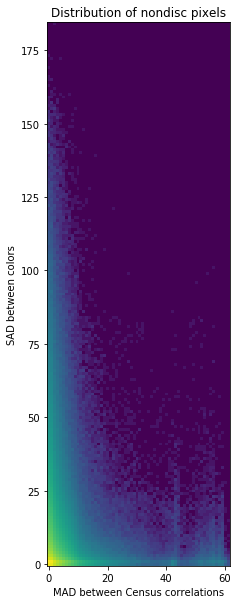

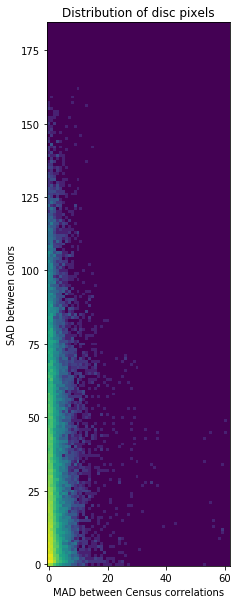

In [7]:
plt.figure(figsize=(10,10))

eps = 1.0/(5*nondisc_cnt.shape[0]*nondisc_cnt.shape[1])

nondisc_cnt2 = (1.0+nondisc_cnt)/ nondisc_cnt.sum() 
plt.imshow(nondisc_cnt2,origin='lower_left',norm=LogNorm())
plt.title('Distribution of nondisc pixels')
plt.xlabel('MAD between Census correlations')
plt.ylabel('SAD between colors')
plt.figure(figsize=(10,10))

disc_cnt2 = (1.0+disc_cnt)/ disc_cnt.sum() + eps
plt.imshow(disc_cnt2,origin='lower_left',norm=LogNorm())
plt.title('Distribution of disc pixels')
plt.xlabel('MAD between Census correlations')
plt.ylabel('SAD between colors')

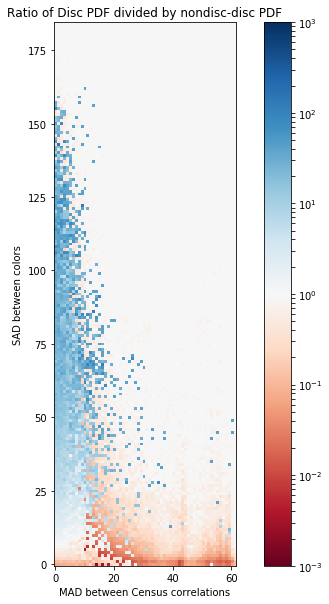

In [8]:
    plt.figure(figsize=(10,10))
    plt.imshow((disc_cnt/disc_cnt.sum()+0.0000008)/(nondisc_cnt/ nondisc_cnt.sum()+0.0000008),origin='lower_left',norm=colors.LogNorm(vmin=1e-3,vmax=1e3),cmap='RdBu')
    plt.title('Ratio of Disc PDF divided by nondisc-disc PDF')
    plt.xlabel('MAD between Census correlations')
    plt.ylabel('SAD between colors')
    plt.colorbar()

In [9]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
abs_x = abs(total[:,1:])
abs_xy = (abs_x[:,0]*abs_x[:,1]).reshape([-1,1])
X = np.hstack([abs_x,abs_xy])
y = total[:,0].astype(np.int)
model = RandomForestClassifier(n_jobs=-1,max_depth=4)#SGDClassifier(n_jobs=-1,loss='hinge',penalty='l2',fit_intercept=True,class_weight='balanced')
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [10]:
model.coef_,model.intercept_

AttributeError: 'RandomForestClassifier' object has no attribute 'coef_'

In [ ]:
model.score(X,y)